In [11]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ruptures as rpt
from icecream import ic

In [12]:
# Data import and cleaning
file_time_a = '../Time Development/Data/time_a.csv'
file_time_b_decay = '../Time Development/Data/time_b_decay.csv'
file_time_b_normal = '../Time Development/Data/time_b_normal.csv'
file_time_b_growth = '../Time Development/Data/time_b_growth.csv'

time_a_df = pd.read_csv(file_time_a)
time_b_decay_df = pd.read_csv(file_time_b_decay)
time_b_normal_df = pd.read_csv(file_time_b_normal)
time_b_growth_df = pd.read_csv(file_time_b_growth)

for df in [time_a_df, time_b_decay_df, time_b_normal_df, time_b_growth_df]:
    if "Unnamed: 0" in df.columns:
        df.drop(columns=["Unnamed: 0"], inplace=True)
    df["Date"] = pd.to_datetime(df["Date"])

In [13]:
# Only care about engagement not CTR
features = ["Engagement"]

In [14]:
import ruptures as rpt
import matplotlib.pyplot as plt

def detect_pelt_changes(time_a_df, time_b_df, scenario_name, feature, penalty=10):
    combined_df = pd.concat([time_a_df, time_b_df], ignore_index=True).sort_values("Date")
    launch_date = time_a_df["Date"].iloc[-1]

    # --- Build daily and rolling average ---
    daily_avg = combined_df.groupby("Date")[feature].mean()
    rolling_avg = daily_avg.rolling(window=7, min_periods=1).mean()

    # ------------------------
    # PELT Detection Helper
    # ------------------------
    def run_pelt(series, penalty_val):
        algo = rpt.Pelt(model="rbf").fit(series.values)
        change_idx = algo.predict(pen=penalty_val)
        # remove last point if it's end of series
        if change_idx[-1] == len(series):
            change_idx = change_idx[:-1]
        return [series.index[i] for i in change_idx]

    change_dates_daily = run_pelt(daily_avg, penalty)
    change_dates_rolling = run_pelt(rolling_avg, penalty)

    # ------------------------
    # Scoring Helper
    # ------------------------
    def score_detection(change_dates, launch_date, scenario_name):
        cps_before = [d for d in change_dates if d < launch_date]
        cps_after = [d for d in change_dates if d > launch_date]
        detected_before = len(cps_before) > 0
        detected_after = len(cps_after) > 0

        if "Normal" in scenario_name:
            TP = 0
            FP = len(cps_before) + len(cps_after)
            FN = 0
            TN = int(not detected_before and not detected_after)
        else:
            TP = int(detected_after)
            FP = len(cps_before)
            FN = int(not detected_after)
            TN = 0

        if TP + FP == 0 and TP + FN == 0:
            precision = recall = f1 = "N/A"
        else:
            precision = TP / (TP + FP) if (TP + FP) > 0 else 0
            recall = TP / (TP + FN) if (TP + FN) > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        return {
            "Change Points": [d.date() for d in change_dates],
            "Days After Launch": [(d - launch_date).days for d in change_dates],
            "Count": len(change_dates),
            "TP": TP, "FP": FP, "FN": FN, "TN": TN,
            "Precision": precision if isinstance(precision, str) else round(precision, 2),
            "Recall": recall if isinstance(recall, str) else round(recall, 2),
            "F1 Score": f1 if isinstance(f1, str) else round(f1, 2)
        }

    # ------------------------
    # Score both Daily and Rolling
    # ------------------------
    daily_scores = score_detection(change_dates_daily, launch_date, scenario_name)
    rolling_scores = score_detection(change_dates_rolling, launch_date, scenario_name)

    # ------------------------
    # Plot - Daily Avg
    # ------------------------
    daily_avg_a = daily_avg[daily_avg.index <= launch_date]
    daily_avg_b = daily_avg[daily_avg.index > launch_date]

    plt.figure(figsize=(10, 5))
    plt.plot(daily_avg_a.index, daily_avg_a.values, label="Time A (Daily Avg)", color="cadetblue")
    plt.plot(daily_avg_b.index, daily_avg_b.values, label="Time B (Daily Avg)", color="mediumslateblue")

    for cp in change_dates_daily:
        color = "green" if cp > launch_date else "orange"
        plt.axvline(x=cp, color=color, linestyle="--", alpha=0.9)

    plt.axvline(x=launch_date, color="red", linestyle="--", label="Product Launch")
    plt.title(f"{feature} - PELT (Daily Avg) ({scenario_name})")
    plt.xlabel("Date")
    plt.ylabel(feature)
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.savefig(f"Model Charts/{scenario_name.replace(' ', '_')}_pelt_daily.png")
    plt.show()

    # ------------------------
    # Plot - Rolling Avg
    # ------------------------
    rolling_avg_a = rolling_avg[rolling_avg.index <= launch_date]
    rolling_avg_b = rolling_avg[rolling_avg.index > launch_date]

    plt.figure(figsize=(10, 5))
    plt.plot(rolling_avg_a.index, rolling_avg_a.values, label="Time A (Rolling 7d Avg)", color="cadetblue")
    plt.plot(rolling_avg_b.index, rolling_avg_b.values, label="Time B (Rolling 7d Avg)", color="mediumslateblue")

    for cp in change_dates_rolling:
        color = "green" if cp > launch_date else "orange"
        plt.axvline(x=cp, color=color, linestyle="--", alpha=0.9)

    plt.axvline(x=launch_date, color="red", linestyle="--", label="Product Launch")
    plt.title(f"{feature} - PELT (Rolling 7d Avg) ({scenario_name})")
    plt.xlabel("Date")
    plt.ylabel(feature)
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.savefig(f"Model Charts/{scenario_name.replace(' ', '_')}_pelt_rolling.png")
    plt.show()

    # ------------------------
    # Return both summaries
    # ------------------------
    daily_summary = {
        "Time B Type": scenario_name.split(" ")[0],
        "Scenario": scenario_name,
        "Feature": feature,
        "Launch Date": launch_date.date(),
        **daily_scores
    }

    rolling_summary = {
        "Time B Type": scenario_name.split(" ")[0],
        "Scenario": scenario_name + " (Rolling 7d Avg)",
        "Feature": feature,
        "Launch Date": launch_date.date(),
        **rolling_scores
    }

    return [daily_summary, rolling_summary]


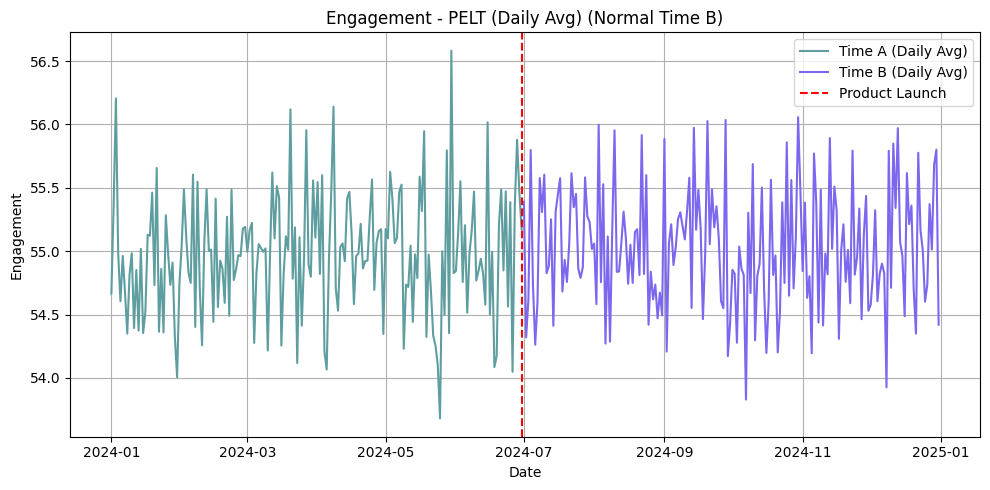

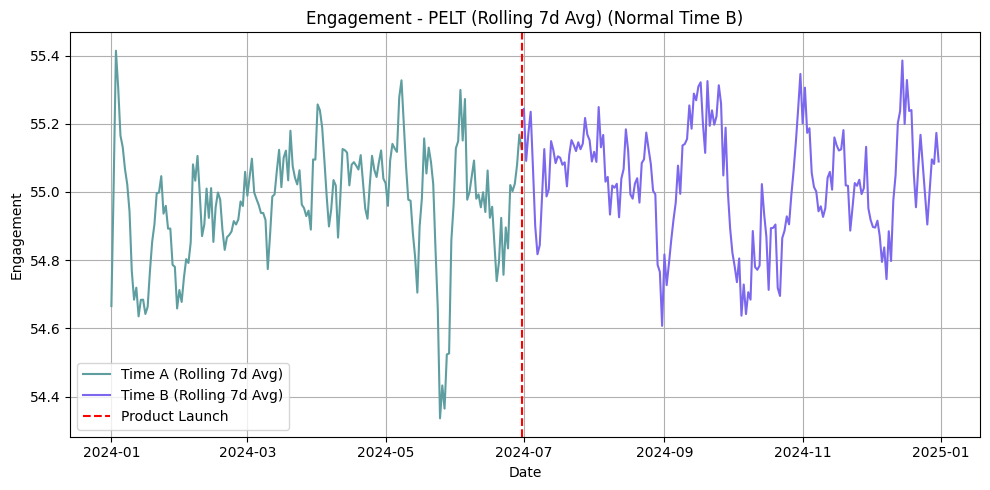

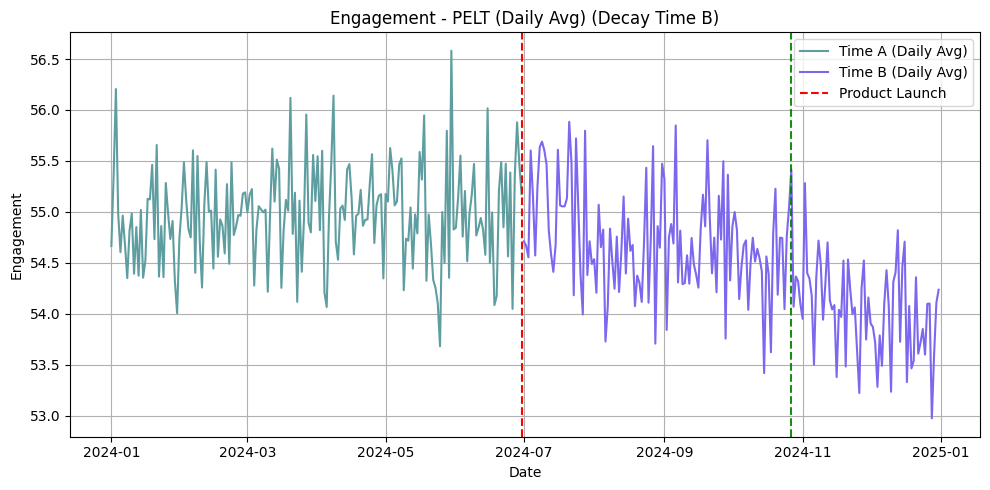

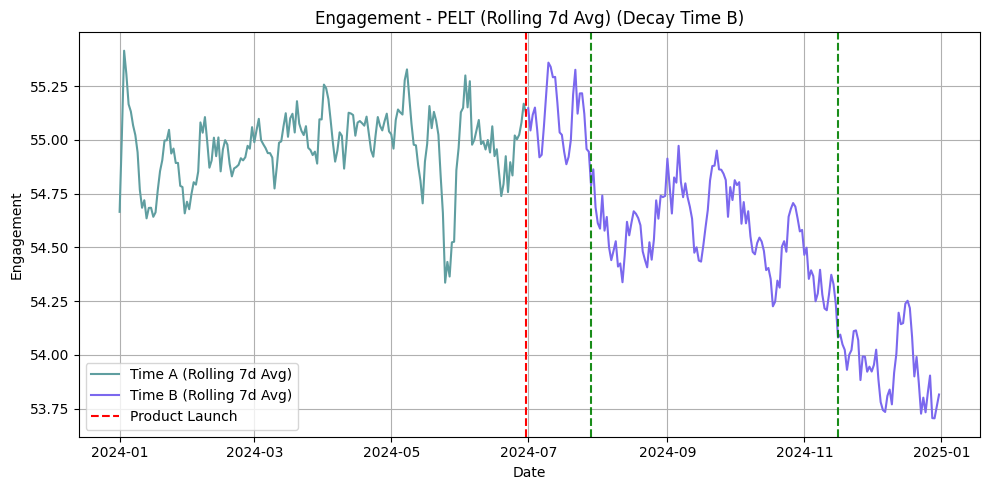

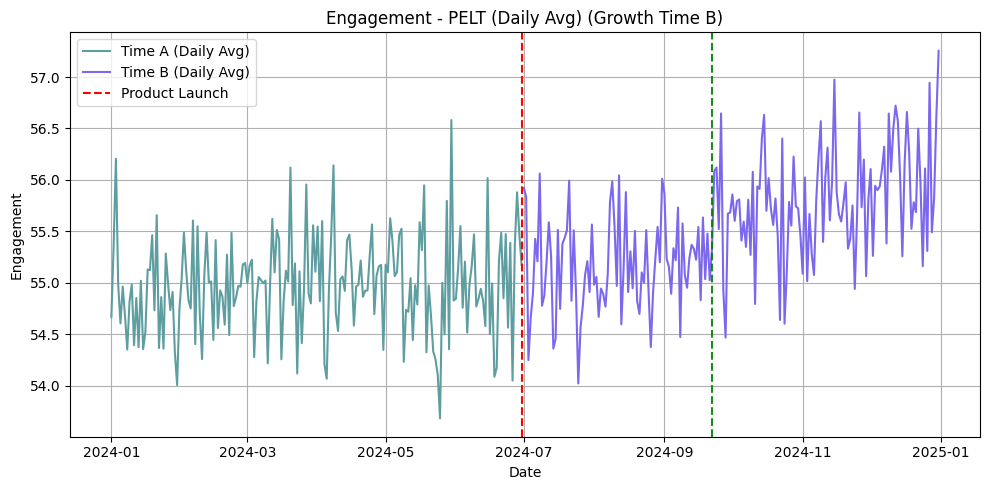

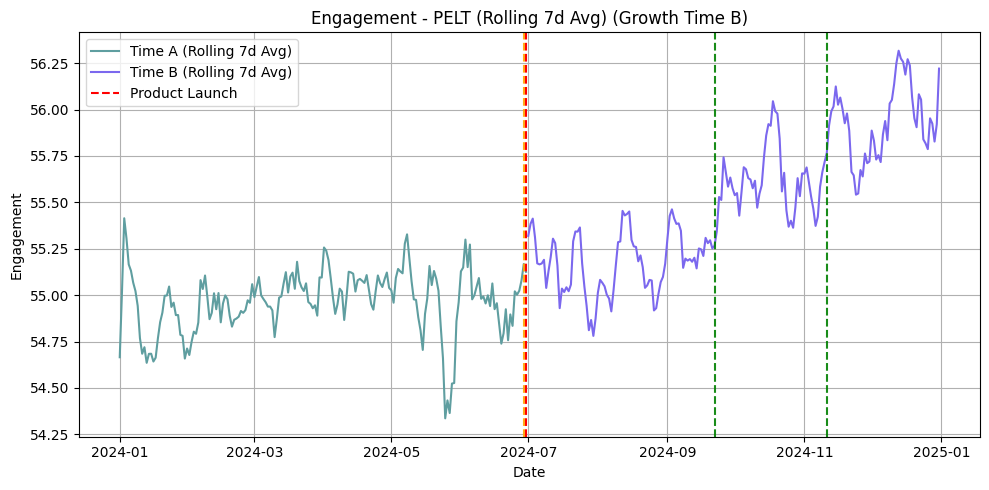

PELT Summary
  Time B Type                        Scenario     Feature Launch Date  \
0      Normal                   Normal Time B  Engagement  2024-06-30   
1      Normal  Normal Time B (Rolling 7d Avg)  Engagement  2024-06-30   
2       Decay                    Decay Time B  Engagement  2024-06-30   
3       Decay   Decay Time B (Rolling 7d Avg)  Engagement  2024-06-30   
4      Growth                   Growth Time B  Engagement  2024-06-30   
5      Growth  Growth Time B (Rolling 7d Avg)  Engagement  2024-06-30   

                          Change Points Days After Launch  Count  TP  FP  FN  \
0                                    []                []      0   0   0   0   
1                                    []                []      0   0   0   0   
2                          [2024-10-27]             [119]      1   1   0   0   
3              [2024-07-29, 2024-11-16]         [29, 139]      2   1   0   0   
4                          [2024-09-22]              [84]      1   1   0   

In [15]:
summary_rows = []

scenarios = {
    "Normal Time B": time_b_normal_df,
    "Decay Time B": time_b_decay_df,
    "Growth Time B": time_b_growth_df
}

for scenario_name, time_b_df in scenarios.items():
    for feature in features:
        summaries = detect_pelt_changes(time_a_df, time_b_df, scenario_name, feature, penalty=10)
        summary_rows.extend(summaries)

summary_df = pd.DataFrame(summary_rows)

print("PELT Summary")
print(summary_df)
